In [1]:
%load_ext autoreload
%autoreload 2

# Compile mmcoremj.jar and copy dll and jar to Micro-Manager installation
import os
from pathlib import Path

os.chdir(r"C:\Users\henry\GitRepos\micro-manager\mmCoreAndDevices\MMCoreJ_wrap")
result = os.system("ant jar")
if result != 0:
    print(f"Error running 'ant jar': exit code {result}")

import shutil
source_1 = r"C:\Users\henry\GitRepos\micro-manager\mmCoreAndDevices\build\Debug\x64\MMCoreJ_wrap.dll"
destination_1 = r"C:\Program Files\Micro-Manager\MMCoreJ_wrap.dll"
source_2 = r"C:\Users\henry\GitRepos\micro-manager\build\Java\MMCoreJ.jar"
destination_2 = r"C:\Program Files\Micro-Manager\plugins\Micro-Manager\MMCoreJ.jar"
shutil.copy2(source_1, destination_1)
shutil.copy2(source_2, destination_2)



'C:\\Program Files\\Micro-Manager\\plugins\\Micro-Manager\\MMCoreJ.jar'

In [2]:
%load_ext autoreload
%autoreload 2

# import the buffer_test_util.py file
import importlib.util
import sys

# Import util file form absolute path
file_path = 'C:/Users/henry/GitRepos/mmpycorex/test/buffer_test_util.py'
spec = importlib.util.spec_from_file_location("buffer_test_util", file_path)
buffer_test_util = importlib.util.module_from_spec(spec)
sys.modules["buffer_test_util"] = buffer_test_util
spec.loader.exec_module(buffer_test_util)

from pycromanager import start_headless, stop_headless, Core
import time
import numpy as np
from buffer_test_util import *

start_headless('C:/Program Files/Micro-Manager', 'MMConfig_demo.cfg', max_memory_mb=9000)

# start_headless('C:/Program Files/Micro-Manager', 'MMConfig_demo.cfg', python_backend=True)
# import pymmcore; print(pymmcore.__version__)

core = Core()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Simple test insert speed bewteen v2 and circular buffer. This tests only inserts and not pops

image_size = 1024
n_images = 200
buffer_size_mb = 8000
n_trials = 3

setup_camera(core, image_size)
results_v2 = run_speed_test(core, image_size, n_images, buffer_size_mb, n_trials, use_v2=True)
results_v1 = run_speed_test(core, image_size, n_images, buffer_size_mb, n_trials, use_v2=False)

print_speed_results(results_v2)
print_speed_results(results_v1)

Trial:   0%|          | 0/3 [00:00<?, ?it/s]

Trial:   0%|          | 0/3 [00:00<?, ?it/s]


=== PERFORMANCE SUMMARY ===
1024x1024 image; 200 images; 8000 MB buffer; 3 trials
Buffer v2=True
  Mean ± SD: 1.514 ± 0.145 GB/s

  95% CI: [1.324, 1.631] GB/s
  Individual trials: 1.601, 1.310, 1.632
  Setup time: 0.083 ± 0.017 s

=== PERFORMANCE SUMMARY ===
1024x1024 image; 200 images; 8000 MB buffer; 3 trials
Buffer v2=False
  Mean ± SD: 1.594 ± 0.062 GB/s

  95% CI: [1.549, 1.675] GB/s
  Individual trials: 1.681, 1.550, 1.549
  Setup time: 3.934 ± 0.510 s


0it [00:00, ?it/s]

Trial:   0%|          | 0/11 [00:00<?, ?it/s]

Trial:   0%|          | 0/11 [00:00<?, ?it/s]

Trial:   0%|          | 0/11 [00:00<?, ?it/s]

Trial:   0%|          | 0/11 [00:00<?, ?it/s]

Trial:   0%|          | 0/11 [00:00<?, ?it/s]

Trial:   0%|          | 0/11 [00:00<?, ?it/s]

Trial:   0%|          | 0/11 [00:00<?, ?it/s]

Trial:   0%|          | 0/11 [00:00<?, ?it/s]

Trial:   0%|          | 0/11 [00:00<?, ?it/s]

Trial:   0%|          | 0/11 [00:00<?, ?it/s]

Trial:   0%|          | 0/11 [00:00<?, ?it/s]

Trial:   0%|          | 0/11 [00:00<?, ?it/s]

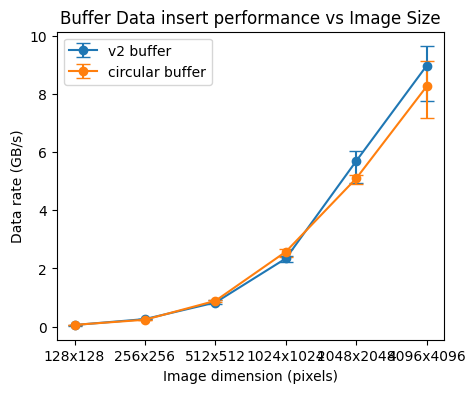

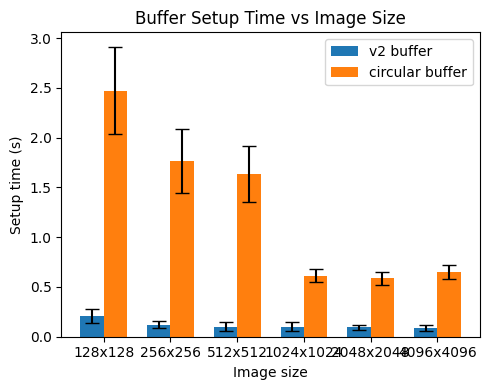

In [3]:
# Test many different image sizes 
image_sizes = np.array([128, 256, 512, 1024, 2048, 4096], dtype=int)
n_trials = 11

MBs_per_image = image_sizes**2 * 2 / 1024 / 1024
buffer_size_mb = 2000
n_images = ((buffer_size_mb - 500) / MBs_per_image).astype(int)
n_images = [int(i) for i in n_images]


all_results = []
for image_size, n_images in tqdm(zip(image_sizes, n_images)):
    setup_camera(core, image_size)
    results_v2 = run_speed_test(core, image_size, n_images, buffer_size_mb, n_trials, use_v2=True)
    results_v1 = run_speed_test(core, image_size, n_images, buffer_size_mb, n_trials, use_v2=False)
    all_results.append((results_v2, results_v1))

# Make plots
# plot performance vs image size
import matplotlib.pyplot as plt
v2_rates = [np.mean(r[0]['data_rates']) for r in all_results]
v2_ci = [np.percentile(r[0]['data_rates'], [2.5, 97.5]) for r in all_results]
v2_errors = np.abs(np.array(v2_ci) - np.array([v2_rates, v2_rates]).T).T  # Convert to absolute errors

v1_rates = [np.mean(r[1]['data_rates']) for r in all_results]
v1_ci = [np.percentile(r[1]['data_rates'], [2.5, 97.5]) for r in all_results]
v1_errors = np.abs(np.array(v1_ci) - np.array([v1_rates, v1_rates]).T).T  # Convert to absolute errors

v2_setup = [np.mean(r[0]['setup_times']) for r in all_results]
v2_setup_errors = [np.std(r[0]['setup_times']) for r in all_results]
v1_setup = [np.mean(r[1]['setup_times']) for r in all_results]
v1_setup_errors = [np.std(r[1]['setup_times']) for r in all_results]

fig, ax = plt.subplots(figsize=(5, 4))
ax.errorbar(image_sizes, v2_rates, xerr=None, yerr=v2_errors, fmt='o-', label='v2 buffer', capsize=5)
ax.errorbar(image_sizes, v1_rates, xerr=None, yerr=v1_errors, fmt='o-', label='circular buffer', capsize=5)
ax.set_xlabel('Image dimension (pixels)')
ax.set_ylabel('Data rate (GB/s)')
ax.legend()
ax.set_title('Buffer Data insert performance vs Image Size')
ax.set_xscale('log', base=2)
ax.set_xticks(image_sizes)
ax.set_xticklabels([f'{i}x{i}' for i in image_sizes])



# Plot 2: Setup times
fig, ax2 = plt.subplots(figsize=(5, 4))
x = np.arange(len(image_sizes))
width = 0.35

ax2.bar(x - width/2, v2_setup, width, yerr=v2_setup_errors, label='v2 buffer', capsize=5)
ax2.bar(x + width/2, v1_setup, width, yerr=v1_setup_errors, label='circular buffer', capsize=5)
ax2.set_xlabel('Image size')
ax2.set_ylabel('Setup time (s)')
ax2.set_title('Buffer Setup Time vs Image Size')
ax2.set_xticks(x)
ax2.set_xticklabels([f'{i}x{i}' for i in image_sizes])
ax2.legend()

plt.tight_layout()

Trial:   0%|          | 0/8 [00:00<?, ?it/s]

Trial:   0%|          | 0/8 [00:00<?, ?it/s]

Trial:   0%|          | 0/8 [00:00<?, ?it/s]

Trial:   0%|          | 0/8 [00:00<?, ?it/s]

Trial:   0%|          | 0/8 [00:00<?, ?it/s]

Trial:   0%|          | 0/8 [00:00<?, ?it/s]

Trial:   0%|          | 0/8 [00:00<?, ?it/s]

Trial:   0%|          | 0/8 [00:00<?, ?it/s]

Trial:   0%|          | 0/8 [00:00<?, ?it/s]

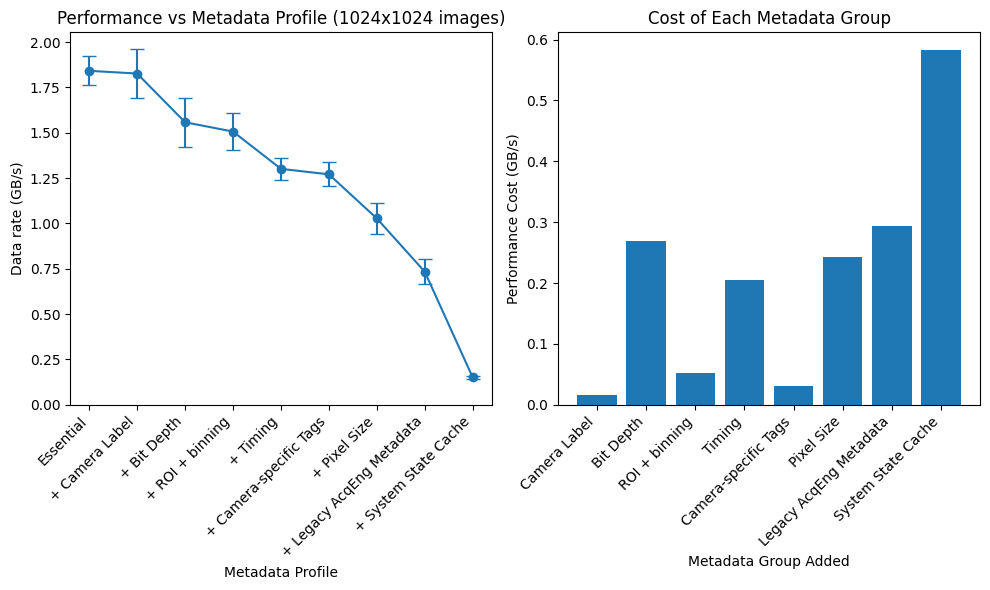

In [6]:
# Test performance with different metadata profiles
image_size = 1024
n_images = 200
buffer_size_mb = 8000
n_trials = 8

metadata_profiles = range(9)  # 0-8 metadata profiles
all_results = []

for profile in metadata_profiles:
    core.set_metadata_profile(profile)
    setup_camera(core, image_size)
    results = run_speed_test(
        core=core,
        image_size=image_size,
        n_images=n_images,
        buffer_size_mb=buffer_size_mb,
        n_trials=n_trials,
        use_v2=True,
    )
    all_results.append(results)
    # print_speed_results(results)

core.set_metadata_profile(0) # reset to default

# Plot results
rates = [np.mean(r['data_rates']) for r in all_results]
errors = [np.std(r['data_rates']) for r in all_results]

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))


metadata_groups = [
    "Essential",                    # 0: Essential (width, height)
    "Camera Label",           # 1: Camera label
    "Bit Depth",             # 2: Image bit depth
    "ROI + binning",       # 3: ROI and binning
    "Timing",                # 4: Image numbers and timestamps
    "Camera-specific Tags",  # 5: All camera specific tags
    "Pixel Size",           # 6: Pixel size and affine transform
    "Legacy AcqEng Metadata",      # 7: Acquisition engine metadata (Frame, position, channel info)
    "System State Cache"    # 8: System state cache
]

# Plot 1: Data rates
ax1.errorbar(metadata_profiles, rates, yerr=errors, fmt='o-', capsize=5)
ax1.set_xlabel('Metadata Profile')
ax1.set_ylabel('Data rate (GB/s)')
ax1.set_title(f'Performance vs Metadata Profile ({image_size}x{image_size} images)')  
names = ['Essential'] + [f'+ {s}' for s in metadata_groups[1:]]
ax1.set_xticks(metadata_profiles)
ax1.set_xticklabels(names, rotation=45, ha='right')
ax1.set_ylim(0, None)

cost = np.array(rates[:-1]) - np.array(rates[1:])
# Plot 2: Cost of each metadata group
ax2.bar(range(len(cost)), cost)
ax2.set_xlabel('Metadata Group Added')
ax2.set_ylabel('Performance Cost (GB/s)')
ax2.set_title('Cost of Each Metadata Group')

# Use metadata group labels, but remove the first one since we're showing differences
ax2.set_xticks(range(len(cost)))
ax2.set_xticklabels(metadata_groups[1:], rotation=45, ha='right')

plt.tight_layout()

In [3]:
# Test performance when acquiring more images than the size of the buffer
image_size = 1024
n_images = 400  # More images to ensure multiple buffer wraps
buffer_size_mb = 200  # Smaller buffer to force wrapping
n_trials = 1
exposure = .1

results_v2 = run_speed_test(core=core, image_size=image_size, n_images=n_images,
    buffer_size_mb=buffer_size_mb, n_trials=n_trials, use_v2=True, exposure=exposure, read_images=True)

results_v1 = run_speed_test(core=core, image_size=image_size, n_images=n_images,
    buffer_size_mb=buffer_size_mb, n_trials=n_trials, use_v2=False, exposure=exposure, read_images=True)

print_speed_results(results_v2)
print_speed_results(results_v1)

Reading images:   0%|          | 0/400 [00:00<?, ?it/s]

Buffer free:   0%|          | 0/400 [00:00<?, ?it/s]

Reading images:   0%|          | 0/400 [00:00<?, ?it/s]

Buffer free:   0%|          | 0/400 [00:00<?, ?it/s]


=== PERFORMANCE SUMMARY ===
1024x1024 image; 400 images; 200 MB buffer; 1 trials
Buffer v2=True
  Mean ± SD: 0.122 ± 0.000 GB/s

  95% CI: [0.122, 0.122] GB/s
  Individual trials: 0.122
  Setup time: 0.005 ± 0.000 s

=== PERFORMANCE SUMMARY ===
1024x1024 image; 400 images; 200 MB buffer; 1 trials
Buffer v2=False
  Mean ± SD: 0.123 ± 0.000 GB/s

  95% CI: [0.123, 0.123] GB/s
  Individual trials: 0.123
  Setup time: 0.098 ± 0.000 s


Text(0.5, 1.0, 'Live mode 1024x1024 images\n200MB buffer\n5.0s duration')

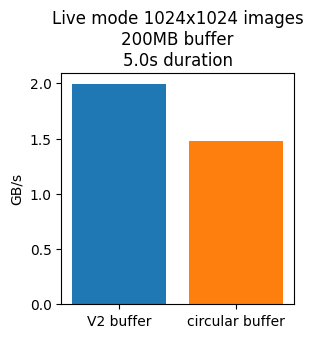

In [8]:
# Speed test live mode frame rates
# Test continuous acquisition (live mode) produces changing images
import numpy as np
from buffer_test_util import *

# Setup camera with desired parameters
image_size = 1024
exposure = 0.000001
MB_per_image = setup_camera(core, image_size, exposure, fast_image=True)
buffer_size = 200
duration = 5.0
# Get image number metadata
core.set_metadata_profile(4)

run_live_mode(core, image_size, use_v2=True, buffer_size_mb=buffer_size, duration=duration, check_for_changing_images=False)
fps_v2 = float(core.get_last_tagged_image().tags['ImageNumber']) / duration

run_live_mode(core, image_size, use_v2=False, buffer_size_mb=buffer_size, duration=duration, check_for_changing_images=False)
fps_v1 = float(core.get_last_tagged_image().tags['ImageNumber']) / duration
core.set_metadata_profile(0)


# convert fps to GB/s
fps_v2_gb = fps_v2 * MB_per_image / 1024
fps_v1_gb = fps_v1 * MB_per_image / 1024
print(f'V2 FPS: {fps_v2}\nV1 FPS: {fps_v1}')
print(f'V2 GB/s: {fps_v2_gb}\nV1 GB/s: {fps_v1_gb}')

# make a bar chart of GB/s
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3, 3))
ax.bar(['V2 buffer', 'circular buffer'], [fps_v2_gb, fps_v1_gb], color=['#1f77b4', '#ff7f0e'])
ax.set_ylabel('GB/s')
ax.set_title(f'Live mode {image_size}x{image_size} images\n{buffer_size}MB buffer\n{duration}s duration')

In [9]:
core.is_buffer_overflowed()

False

In [3]:
from time import time, sleep

# Test speed savings from pointers vs copies
n_images = 2000
image_size = 2048
buffer_size_mb = int(1.25 * image_size**2 * 2 / 1024**2) * n_images

elapsed_times = {}
for pointer_mode in [True, False]:
    MB_per_image = setup_camera(core, image_size)
    core.enable_v2_buffer(True)
    core.set_buffer_memory_footprint(buffer_size_mb)
    core.start_sequence_acquisition(n_images, 0, True)

    while core.is_sequence_running():
        sleep(0.01)
    # check for overflow
    if core.is_buffer_overflowed():
        raise Exception('Buffer overflowed')
    
    start_time = time()
    for _ in tqdm(range(n_images), desc='Reading images'):
        if pointer_mode:
            p = core.pop_next_tagged_image_pointer()
            p.release()
        else:
            core.pop_next_tagged_image()

    elapsed_times[pointer_mode] = time() - start_time

pointer_readout_time = elapsed_times[True] / n_images
pointer_readout_time_gb = MB_per_image / 1024 / pointer_readout_time

copy_readout_time = elapsed_times[False] / n_images
copy_readout_time_gb = MB_per_image / 1024 / copy_readout_time

print(f'Pointer readout time GB/s: {pointer_readout_time_gb}')
print(f'Copy readout time GB/s: {copy_readout_time_gb}')


Reading images:   0%|          | 0/2000 [00:00<?, ?it/s]

Reading images:   0%|          | 0/2000 [00:00<?, ?it/s]

Pointer readout time GB/s: 4.187693206998795
Copy readout time GB/s: 2.2820639544105354
